In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import pandas as pd

import sys
print(sys.version)

import mmml

# import pyscf

3.12.0 (main, Oct  3 2023, 01:27:23) [Clang 17.0.1 ]


In [2]:
!which python
# ! uv pip install pyscf

/pchem-data/meuwly/boittier/home/mmml/.venv/bin/python


In [114]:
import numpy as np
import cupy
from gpu4pyscf.scf import hf, cphf, _response_functions
from gpu4pyscf.lib.cupy_helper import contract

def gen_vind(mf, mo_coeff, mo_occ):
    """get the induced potential. This is the same as contract the mo1 with the kernel.

    Args:
        mf: mean field object
        mo_coeff (numpy.array): mo coefficients
        mo_occ (numpy.array): mo_coefficients

    Returns:
        fx (function): a function to calculate the induced potential with the input as the mo1.
    """
    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:, mo_occ > 0]
    mvir = mo_coeff[:, mo_occ == 0]
    nocc = mocc.shape[1]
    nvir = nmo - nocc
    vresp = mf.gen_response(mo_coeff, mo_occ, hermi=1)

    def fx(mo1):
        mo1 = mo1.reshape(-1, nvir, nocc)  # * the saving pattern
        mo1_mo_real = contract('nai,ua->nui', mo1, mvir)
        dm1 = 2*contract('nui,vi->nuv', mo1_mo_real, mocc.conj())
        dm1+= dm1.transpose(0,2,1)

        v1 = vresp(dm1)  # (nset, nao, nao)
        tmp = contract('nuv,vi->nui', v1, mocc)
        v1vo = contract('nui,ua->nai', tmp, mvir.conj())

        return v1vo
    return fx


def eval_polarizability(mf):
    """main function to calculate the polarizability

    Args:
        mf: mean field object

    Returns:
        polarizability (numpy.array): polarizability in au
    """
    assert isinstance(mf, hf.RHF), "Unrestricted mf object is not supported."

    polarizability = np.empty((3, 3))

    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    mo_energy = mf.mo_energy
    mo_coeff = mo_coeff #cupy.array(mo_coeff)
    mo_occ = mo_occ #cupy.array(mo_occ)
    mo_energy = mo_energy
    fx = gen_vind(mf, mo_coeff, mo_occ)
    mocc = mo_coeff[:, mo_occ > 0]
    mvir = mo_coeff[:, mo_occ == 0]

    with mf.mol.with_common_orig((0, 0, 0)):
        h1 = mf.mol.intor('int1e_r')
        h1 = cupy.array(h1)
    for idirect in range(3):
        print(h1[idirect].shape)
        print(h1[idirect].sum(axis=1))
        h1ai = -mvir.T.conj()@h1[idirect]@mocc
        mo1 = cphf.solve(fx, mo_energy, mo_occ, h1ai,  max_cycle=20, tol=1e-10)[0]
        for jdirect in range(idirect, 3):
            p10 = np.trace(mo1.conj().T@mvir.conj().T@h1[jdirect]@mocc)*2
            p01 = np.trace(mocc.conj().T@h1[jdirect]@mvir@mo1)*2
            polarizability[idirect, jdirect] = p10+p01
    polarizability[1, 0] = polarizability[0, 1]
    polarizability[2, 0] = polarizability[0, 2]
    polarizability[2, 1] = polarizability[1, 2]

    return polarizability, h1


In [115]:
from mmml.pyscf4gpuInterface.calcs import setup_mol

In [505]:
mol_str = """O     -2.217302    2.805476    2.146856 
H     -2.260473    3.658861    2.578259    
H     -2.256339    3.006951    1.211915  """

In [907]:
mf, mol = setup_mol(mol_str, "def2-tzvp", "PBE0", 0, 0)

overwrite output file: ./pyscf.log


In [908]:
?mf.get_veff

Signature: mf.get_veff(mol=None, dm=None, dm_last=None, vhf_last=0, hermi=1)
Docstring: effective potential
File:      ~/mmml/.venv/lib/python3.12/site-packages/gpu4pyscf/df/df_jk.py
Type:      method

In [909]:
dir(mf)
# mf.mo_energy.sum()

['CasidaTDDFT',
 'DIIS',
 'Gradients',
 'Hessian',
 'PCM',
 'SMD',
 'TDA',
 'TDDFT',
 'TDDFTNoHybrid',
 'TDHF',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name_mixin__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_eigh',
 '_eri',
 '_finalize',
 '_is_mem_enough',
 '_keys',
 '_numint',
 '_opt_gpu',
 'analyze',
 'apply',
 'as_scanner',
 'auxbasis',
 'build',
 'callback',
 'canonicalize',
 'check_convergence',
 'check_sanity',
 'chkfile',
 'conv_check',
 'conv_tol',
 'conv_tol_cpscf',
 'conv_tol_grad',
 'converged',
 'copy',
 'cphf_grids',
 'damp',
 'define_xc_',
 'density_fit',
 'device',
 'diis',
 'diis_damp',
 'diis_file',
 'diis_space',
 'diis_space_rollb

In [910]:
mf.kernel()

-76.3773370272375

In [911]:
mf.dip_moment(unit="") 

array([-0.05727563,  0.7349374 , -0.35082401])

In [650]:
from pyscf import gto, scf, tools
dm_init_guess = [None]
def apply_field(E, mol):
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = scf.RHF(mol)
    mf.get_hcore = lambda *args: h
    mf.scf(dm_init_guess[0])
    dm_init_guess[0] = mf.make_rdm1()
    e = mf.kernel()    
    dip_m = mf.dip_moment()
    return e, dip_m
    # mo = mf.mo_coeff #[:,mo_id]
    # print(mf)
    # # if mo[23] < -1e-5:  # To ensure that all MOs have same phase
    #     # mo *= -1
    # return mo

In [657]:
t0, dipole_m0 = apply_field(np.zeros(3), mol)
# np.linalg.norm(t0)
# np.sum(t0)
t0, dipole_m0

(-76.05904280717294, array([-0.15137997,  1.94244428, -0.92722976]))

In [662]:
dipole_m0[1]/dipole_m0[0], dipole_m0[2]/dipole_m0[0], dipole_m0[1]/dipole_m0[2]

(-12.831580771483527, 6.125181395716535, -2.0948899212122787)

In [792]:
# for i in range(np.zeros((3,3))
mol.intor('cint1e_r_sph', comp=3).shape

(3, 43, 43)

In [925]:
dE = 10**-4
out_p = []
out_alpha = []
for E in np.eye(3).reshape(3, 3)*dE :
    
    
    def apply_field(E):
        dm_init_guess = [None]
        # mf, mol = setup_mol(mol_str, "def2-tzvp", "PBE0", 0, 0)
        mol = pyscf.M(
        atom=mol_str,                         # water molecule
        basis="def2-tzvp",                # basis set
        spin=0,
        charge=0,
        unit="B",
        # output=log_file,              # save log file
        # verbose=verbose                          # control the level of print info
        )
        mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
        h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
          + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
        mf = rks.RKS(mol, xc="PBE0").density_fit()  
        mf.get_hcore = lambda *args: h
        mf.scf(dm_init_guess[0])
        # dm_init_guess[0] = mf.make_rdm1()
        e = mf.kernel()  
        mf.get_veff()
        # print(mf.scf_summary)
        e = mf.scf_summary["coul"]
        dip_m = mf.dip_moment(unit="AU")
        return e, dip_m
        
    # print(E)
    
    t0, dipole_m0 = apply_field(np.zeros(3))
    mol = pyscf.M(
            atom=mol_str,                         # water molecule
            basis="def2-tzvp",                # basis set
            spin=0,
            charge=0,
            unit="B",
            # output=log_file,              # save log file
            # verbose=verbose                          # control the level of print info
            )
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = rks.RKS(mol, xc="PBE0").density_fit()  
    t1, dipole_m1 = apply_field(E)
    mol = pyscf.M(
            atom=mol_str,                         # water molecule
            basis="def2-tzvp",                # basis set
            spin=0,
            charge=0,
            unit="B",
            # output=log_file,              # save log file
            # verbose=verbose                          # control the level of print info
            )
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = rks.RKS(mol, xc="PBE0").density_fit()  
    t2, dipole_m2 = apply_field(-1*E)
    dplus = (t0 - t1)
    dminus = (t0 - t2)
    dm_dE1 = (dipole_m0 - dipole_m1)
    dm_dE2 = (dipole_m0 - dipole_m2)

    out_alpha.append((dm_dE1 - dm_dE2))
    out_p.append((dplus - dminus))

converged SCF energy = -74.9278282380878
converged SCF energy = -74.9278282380884
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60122, -0.28700
converged SCF energy = -74.9300490979195
converged SCF energy = -74.9300490979201
Dipole moment(X, Y, Z, A.U.): -0.04640,  0.60123, -0.28700
converged SCF energy = -74.9256074232754
converged SCF energy = -74.925607423276
Dipole moment(X, Y, Z, A.U.): -0.04730,  0.60122, -0.28699
converged SCF energy = -74.9278282380878
converged SCF energy = -74.9278282380884
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60122, -0.28700
converged SCF energy = -74.9249774140436
converged SCF energy = -74.9249774140442
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60153, -0.28699
converged SCF energy = -74.9306790931421
converged SCF energy = -74.9306790931427
Dipole moment(X, Y, Z, A.U.): -0.04686,  0.60091, -0.28700
converged SCF energy = -74.9278282380878
converged SCF energy = -74.9278282380884
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60122, -0.28700
converged SCF 

In [926]:
from gpu4pyscf.properties import polarizability

mol = pyscf.M(
atom=mol_str,                         # water molecule
basis="def2-tzvp",                # basis set
spin=0,
charge=0,
unit="B",
# output=log_file,              # save log file
# verbose=verbose                          # control the level of print info
)
mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
# h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
#   + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
mf = rks.RKS(mol, xc="PBE0").density_fit()  

mf.kernel()
print("polarizability tensor")
print(polarizability.eval_polarizability(mf))
print(mf.dip_moment(unit="AU"))

converged SCF energy = -74.9278282380878
polarizability tensor
[[ 4.50194184  0.09208974 -0.03994215]
 [ 0.09208974  3.10102805  0.03815565]
 [-0.03994215  0.03815565  3.16208189]]
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60123, -0.28700
[-0.04685482  0.60122507 -0.28699598]


In [936]:
1/1.62452981

0.6155627270391547

In [942]:
ans = np.array(out_p) / dE /np.pi
ans

array([-0.04845763,  0.62178304, -0.29681203])

In [943]:
ans/mf.dip_moment(unit="")/np.pi

Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60123, -0.28700


array([0.32919857, 0.32919401, 0.32919696])

In [924]:
[-0.5 * _ / dE for _ in out_alpha]

[array([ 4.50196119,  0.0920895 , -0.03994214]),
 array([0.09209103, 3.10104491, 0.03817404]),
 array([-0.03994255,  0.03816993,  3.16212412])]

In [880]:
# mol.intor('cint1e_r_sph', comp=3).sum()

In [705]:
# mf.mo_energy.sum() 

In [535]:
mf.mo_energy.sum() #* ase.units.Hartree

array(134.80098689)

In [558]:
polar, h1 = eval_polarizability(mf)

(43, 43)
[ -8.82859683 -12.44563097 -17.61462416 -20.98436119 -21.94619891
  -6.62252182  -8.06788231  -4.7738041   -7.74884255 -13.62417468
  -5.06725107  -4.65454145 -15.20379421  -5.31097181  -5.91440117
  -5.03229879  -7.70210387  -5.5807025   -5.14708083  -5.78252694
  -4.74732013  -9.38112545  -4.43287     -1.96492472  -2.58505485
  -4.05717321  -6.59440273  -3.79614409  -4.20507076  -3.25425193
  -2.55019082 -15.79832286 -25.81502627 -23.18707459  -7.560056
   6.13503223  -4.38432477  -9.89206399 -14.22023695 -16.05217521
  -4.23482691  -5.41045093  -8.03715352]
(43, 43)
[11.21957383 16.13861789 24.9192189  31.96585258 36.02858719 11.63845598
 12.03675993  7.17275667 16.63093111 22.27847041  8.27235932 14.14042196
 26.97964734  8.3286653   9.27319184  6.72782132  9.49074816  8.0604904
  7.45011266 12.08165157  7.26050006 10.96263485  7.45403916  2.87866934
  5.26013357  6.57673506  9.45061544  3.4164907   6.13660463  4.20297729
  3.08437854 26.67578997 43.99898666 40.5453402  17

In [560]:
h1.sum(axis=(1,2))

array([-364.07751861,  590.46629827,  444.74947188])

In [530]:
mf.dip_moment(unit="B") @ (1/polar)

array([-19.61635525,   0.13620998,  -0.46024868])

In [549]:
np.linalg.norm ( np.linalg.norm(mf.dip_moment(unit="B")) * (1/polar))

38.43564619233012

In [521]:
mf.dip_moment() * ase.units.Debye / ase.units.Bohr

array([-0.05727562,  0.73493739, -0.35082401])

In [455]:
_ = -h1.sum(axis=(1,2))
_.sum()

array(-672.50202177)

In [456]:
file_path = Path("~/mmml/tests/functionality/esp")
data_path = file_path / "water.xyz.npz"
data = pd.read_pickle(data_path)

In [489]:
# data["energy"] / ase.units.Hartree

In [458]:
data.keys()

dict_keys(['mol', 'calcs', 'opt_callback', 'energy', 'esp', 'esp_out', 'sorted_idxs', 'grid_indices', 'esp_grid', 'mol_coords_angstrom', 'mol_z', 'dipole', 'quadrupole', 'density', 'grid_dens', 'grid_esp', 'esp_indices', 'gradient', 'shielding', 'polarizability'])

In [473]:
alpha  = data["polarizability"] * (ase.units.Bohr)**3
alpha 

array([[ 0.77669076, -0.01250175,  0.004772  ],
       [-0.01250175,  1.00347174,  0.07983046],
       [ 0.004772  ,  0.07983046,  1.13278616]])

In [474]:
np.ones(3)

array([1., 1., 1.])

In [475]:
p = data["dipole"] * ase.units.Debye #/ ase.units.Bohr
p

array([-0.03030896,  0.38891212, -0.18564807])

In [476]:
p_norm = np.linalg.norm(p)
p_norm

0.4320144391345648

In [477]:
np.trace(p_norm / alpha)

1.368117636923897

In [546]:
np.linalg.norm(p_norm / alpha) 

137.25620056910512

In [742]:
mf, mol = setup_mol(mol_str, "def2-tzvp", "PBE0", 0, 0)
mf.kernel()
mf.get_veff().shape

overwrite output file: ./pyscf.log


(43, 43)

In [743]:
mf.scf_summary

{'e1': -123.09737703248709,
 'coul': 46.78612547475179,
 'exc': -9.26103719528753,
 'nuc': 9.194951725785334}

In [481]:
mf.scf_summary["exc"] + mf.scf_summary["nuc"]

-0.023363551998356158

In [550]:
mf.scf_summary["coul"] - mf.scf_summary["nuc"] #+ mf.scf_summary["exc"]

37.59116819491817

In [483]:
mf.scf_summary["e1"] - mf.scf_summary["exc"] + mf.scf_summary["nuc"]

-104.67245845989044

In [484]:
mf.scf_summary["e1"] + mf.scf_summary["exc"] + mf.scf_summary["coul"] + mf.scf_summary["nuc"]

-76.37718438355935

In [485]:
mf.scf_summary["e1"] + mf.scf_summary["exc"] + mf.scf_summary["nuc"]

-123.20444705805099

In [486]:
mf.dip_moment()

array([-0.14604   ,  1.8710922 , -0.88329239])

In [336]:
mf.e_tot

-76.3773370272375

In [303]:
mf.mo_energy.sum()

array(134.80099425)

In [306]:
-mf.mo_energy.sum(), (p/alpha).sum() 

(array(-134.80099425), -19.94039366769672)

In [5]:
esp = data["esp"]
esp.shape

(1910,)

In [285]:
sum_aux_basis = np.array([ 0.00010188, -0.0013073,   0.00062407])
sum_aux_basis.sum()

-0.00058135

In [6]:
esp_out = data["esp_out"]
esp_out.shape

(1748,)

In [7]:
sorted_idxs = data["sorted_idxs"]
sorted_idxs.shape, sorted_idxs.max()

((1748,), 1909)

In [8]:
esp[sorted_idxs]

array([-0.26873364, -0.26673155, -0.26549337, ...,  0.20839602,
        0.20840397,  0.20873471])

In [9]:
esp_grid = data["grid_esp"]
esp_grid.shape

(1910, 3)

In [10]:
esp_grid[sorted_idxs]

array([[-4.70087061,  7.12184458,  0.41306187],
       [-4.41829593,  9.31087399,  5.01882443],
       [-3.75054797,  7.4125607 ,  7.13880695],
       ...,
       [-6.58195244,  5.68231386,  1.28907577],
       [-4.67781416,  7.86950147,  1.37822277],
       [-6.31610085,  7.73455195,  2.55889625]])

In [11]:
dens = data["density"].get()
dens.shape

(97792,)

In [12]:
grid_dens = data["grid_dens"]
grid_dens.shape

(97792, 3)

In [13]:
esp_idxs = data["esp_indices"]
esp_idxs.shape

(1748,)

In [14]:
grid_dens[esp_idxs].shape

(1748, 3)

In [15]:
esp_idxs.max()

97565

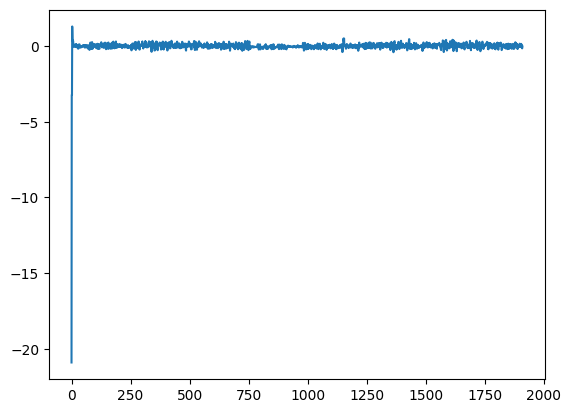

In [16]:
_ = plt.plot(esp)

(-0.1, 0.1)

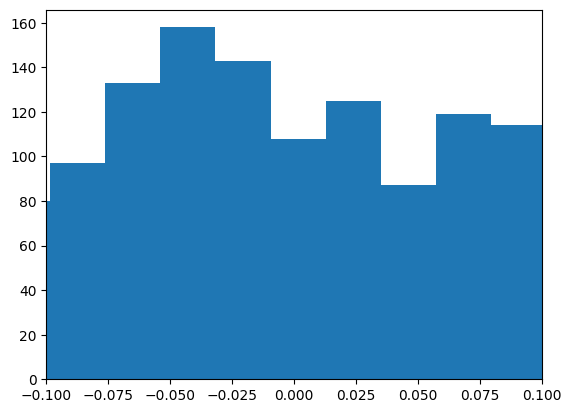

In [17]:
_ = plt.hist(esp, bins=1000)
plt.xlim(-0.1, 0.1)

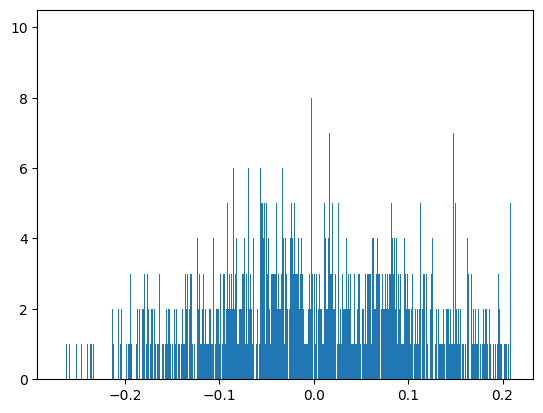

In [18]:
_ = plt.hist(esp_out, bins=1000)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

def plot_3d_scatter_views(coords, color_values, cmap_name='plasma', angles=[(20, 45), (90, -90), (0, 0)], vmin=None, vmax=None):
    """
    Plots a 3D scatter plot from coords and color_values, shown from 3 different angles.
    
    Parameters:
    - coords: (n, 3) array of xyz coordinates
    - color_values: (n,) array of scalar values used for colormap
    - cmap_name: string, name of matplotlib colormap
    - angles: list of (elev, azim) tuples for different 3D views
    """
    assert coords.shape[1] == 3, "Input coords must be of shape (n, 3)"
    assert coords.shape[0] == len(color_values), "color_values must have same length as number of points"
    if vmin is None:
        vmin = color_values.min()
    if vmax is None:
        vmax=color_values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    mapped_colors = cmap(norm(color_values))

    fig = plt.figure(figsize=(18, 6))
    
    for i, (elev, azim) in enumerate(angles):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                   c=mapped_colors, s=20, edgecolor='k', alpha=0.9)
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f"View {i+1} (elev={elev}, azim={azim})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
    
    # Add shared colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(color_values)
    cbar = plt.colorbar(mappable, ax=fig.axes, orientation='horizontal', fraction=0.02, pad=0.4)
    cbar.set_label("ESP [(Hartree/Bohr) / $e$]")

    plt.tight_layout()
    plt.show()


In [20]:
esp.sum(), esp_out.sum()

(3.3144722545851923, 0.3034676838205854)

In [21]:
esp.mean(), esp_out.mean()

(0.0017353257877409385, 0.00017360851477150196)

In [22]:
np.median(esp), np.median(esp_out)

(0.006233426274140363, -0.004288673627481643)

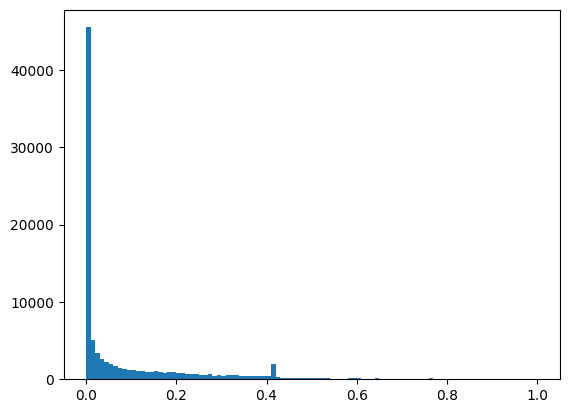

In [23]:
_ = plt.hist(dens, bins=100, range=(0,1))

In [24]:
esp_grid.shape, esp.shape

((1910, 3), (1910,))

/tmp/ipykernel_17786/1874149195.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_17786/1874149195.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


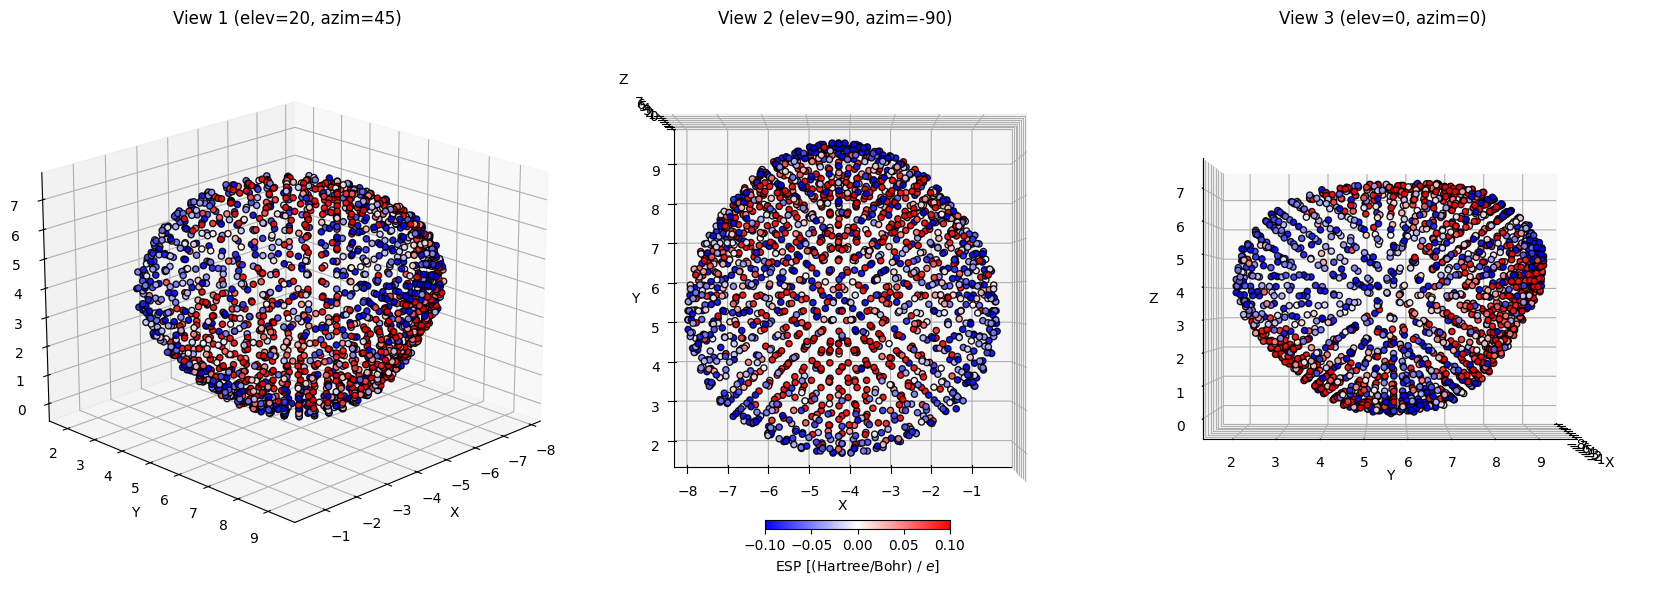

In [25]:
plot_3d_scatter_views(esp_grid, esp, vmin=-0.1, vmax=0.1, cmap_name="bwr")

/tmp/ipykernel_17786/1874149195.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_17786/1874149195.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


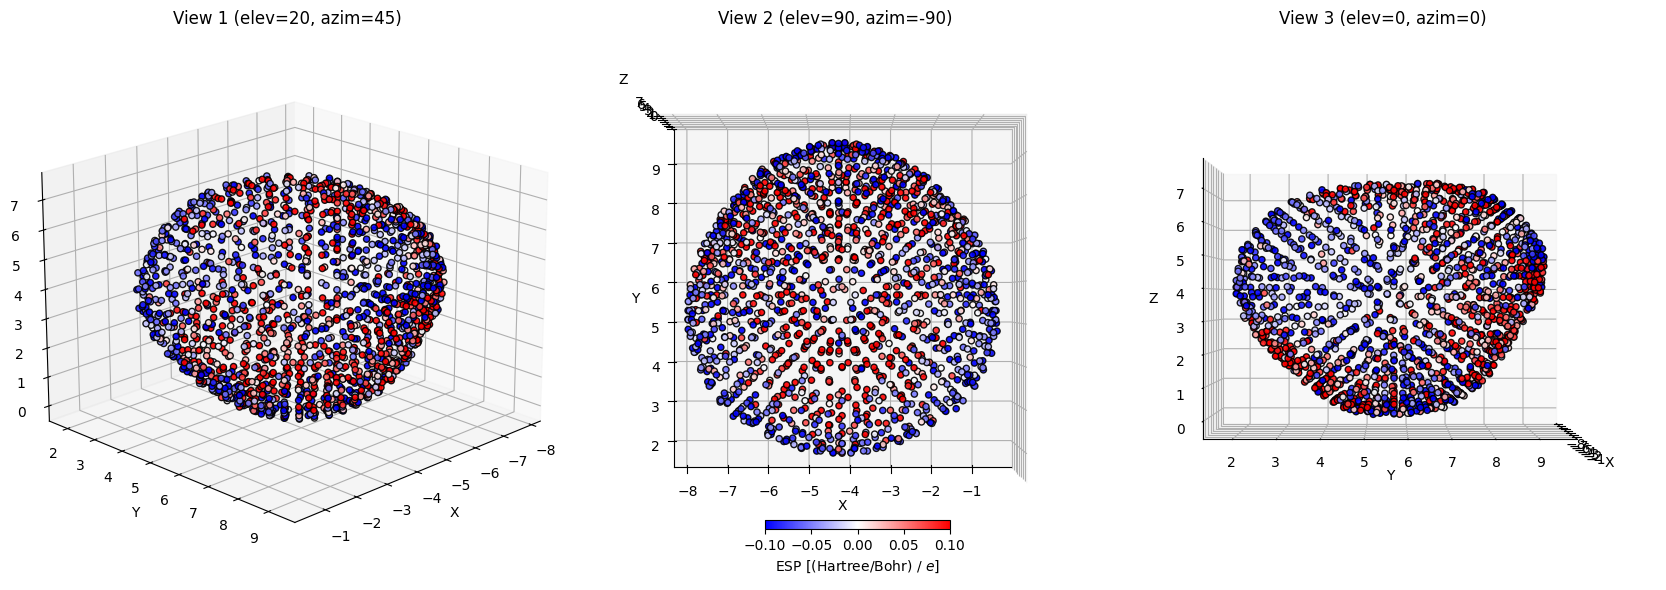

In [35]:
plot_3d_scatter_views(esp_grid[sorted_idxs], esp_out, vmin=-0.1, vmax=0.1, cmap_name="bwr")

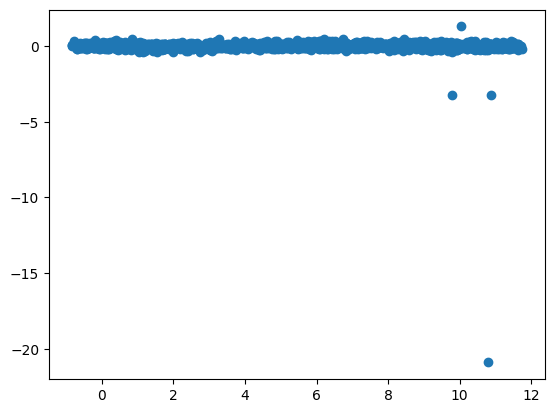

In [27]:
plt.scatter(esp_grid.sum(axis=1), esp)

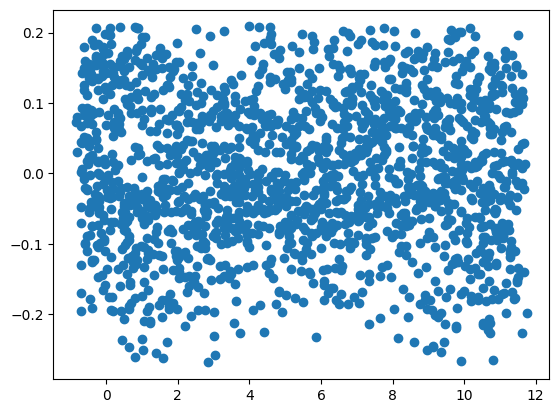

In [28]:
plt.scatter(esp_grid[sorted_idxs].sum(axis=1), esp_out)

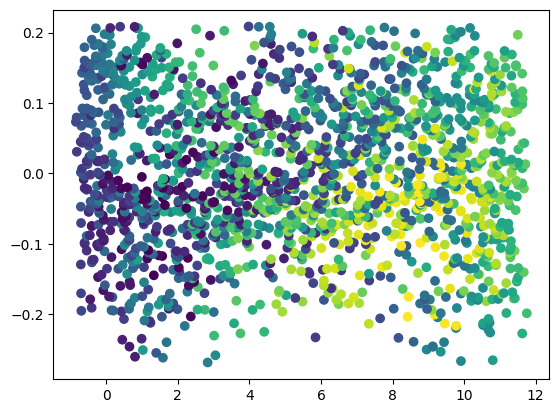

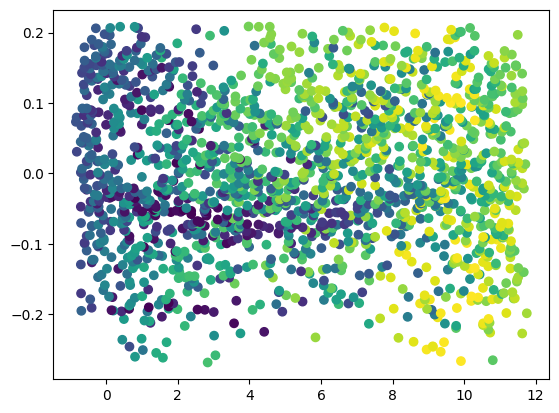

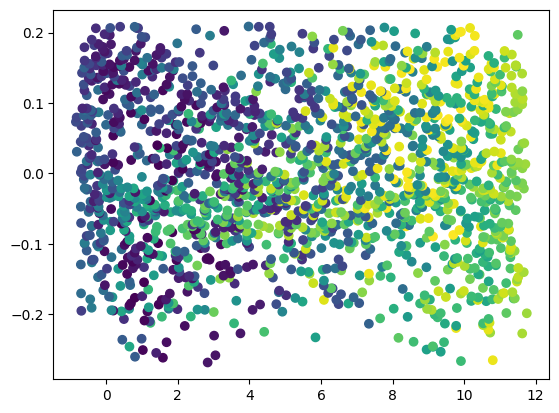

In [29]:
X,Y,Z = esp_grid[sorted_idxs].T
plt.scatter(esp_grid[sorted_idxs].sum(axis=1), esp_out, c=X)
plt.show()
plt.scatter(esp_grid[sorted_idxs].sum(axis=1), esp_out, c=Y)
plt.show()
plt.scatter(esp_grid[sorted_idxs].sum(axis=1), esp_out, c=Z)